In [25]:
import numpy as np
import matplotlib.pyplot as plt
from math import fabs
%matplotlib inline

In [26]:
# functions to compute steady state cell fractions and cluster distributions

# compute the term in cluster escape flux coming from clusters of size m (fixed) from function cluster_sum()
def subcluster_sum(cp, e, h, m, s, pE, pH, two_dim=False):
    # if two_true -> effective-2D model 
	
    # relative fraction of E and M cells (to estimate nearest neighbors)
	ef = e/(e+m)
	mf = m/(e+m)
	
	vec = np.zeros(s)
	
	# term coming from cluster of size s
	if two_dim:
		nE = 2*e/(e+m) + 2*s*e
		nH = s*h
		vec[s-1] = (s**cp)*( pE**nE )*( pH**nH )
	else:
		nE = 2*e/(e+m)
		vec[s-1] = (s**cp)*( pE**nE )
	
	
	# terms from subclusters of size<s
	if s>1:
		# summation on k=[2,s]
		for p in np.arange(1,s,1):
			ms = float(p) # make it float for division
			if two_dim:
				nE = (2/(s-ms+1))*(e/(e+m)) + 2*ms*e
				nH = (2/(s-ms+1)) + ((s-ms-1)/(s-ms+1)) + 2*ms*h
				vec[p-1] = (ms**cp)*( pE**nE )*( pH**nH )
			else:
				nE = (2/(s-ms+1))*(e/(e+m))
				nH = (2/(s-ms+1)) + ((s-ms-1)/(s-ms+1))
				vec[p-1] = (ms**cp)*( pE**nE )*( pH**nH )
	return vec


# compute the instantaneous flux term 
def cluster_sum(cp, e, h, m, pE, pH, two_dim=False):
	# if no hybrid cells, return 0.
	if h==0:
		return 0., np.array([])
	else:
		epsilon = 0.0001 #threshold for precise estimation of flux
		c = 0. # c stores the incremental value of flux
		s = 1
		# vector to store contribution to escape rate by clusters if size s
		clst_list = []
        # loop through all cluster sizes (s) in the lattice
		while ( s>0 ):
			sub_cont = subcluster_sum(cp, e, h, m, s, pE, pH, two_dim=two_dim)
			inc = (h**s)*((1-h)**2)*(2/(s*(s+1)))*np.sum( sub_cont )
			clst_list.append( (h**s)*((1-h)**2)*(2/(s*(s+1)))*( sub_cont ) )
			c = c + inc
			s = s + 1
			# when exceeding cutoff, stop summing
			if inc/c < epsilon:
				break
		return c, clst_list


# function to compute steady state flux, slightly different
def cluster_final(num, cp, e, h, m, pE, pH, two_dim=False):
	
	if h==0:
		return 0., np.array([])
	else:
		epsilon = 0.0001
		c = 0.
		# vector to store contribution to escape rate by clusters if size s
		clst_list = []
		for s in np.arange(1,num+1,1):
			sub_cont = subcluster_sum(cp, e, h, m, s, pE, pH, two_dim=two_dim)
			inc = ( 2*(h**s)*((1-h)**2)/(s*(s+1)) )*np.sum( sub_cont )
			clst_list.append( ( 2*(h**s)*((1-h)**2)/(s*(s+1)) )*( sub_cont ) )
			c = c + inc

		return c, clst_list
    
    
# find final cluster distribution
def find_dist(clst_list):
	maxs = len(clst_list)
	rates = np.zeros((maxs, maxs))
	dist = np.zeros(maxs)

	for i in range(maxs):
		for j in range(maxs):
			if j<clst_list[i].size:
				rates[i][j] = clst_list[i][j]
			else:
				rates[i][j] = 0.

	for i in range(maxs):
		dist[i] = np.sum( rates[:,i] )

	return dist
    
    
# steepest descent to solve for cell fractions
def solve(k, c, e0, h0, m0, pE, pH):
	
	if k<0.01:
		L = 20
	elif k<10.:
		L = 10
	else:
		L = 2

	e, h, m = e0, h0, m0
	count = 0
	
	epsilon = 0.0001

	sum = 0.
	while ( fabs(h-sum)>epsilon ):

		s, list = cluster_sum(c, e, h, m, pE, pH, two_dim=True)
		
		sum = ( 1-(1./k)*s )/(k+2)
		
		hs = ( 1-(1./k)*s )/(k+2)
		ms = k*( 1-(1./k)*s )/(k+2)
		es = 1. - (1+k)*( 1-(1./k)*s )/(k+2)
		
		dh = (h-hs)/L
		dm = (m-ms)/L
		de = (e-es)/L
		
		h = h - dh
		if h<0.:
			h = 0.
		m = m - dm
		if m<0.:
			m = 0.
		e = e - de
		if e<0.:
			e = 0.
		count = count + 1

	return e, h, m

Cell fractions as a function of the rate k (at constant c=1)

In [27]:
# adhesion parameters
pE = 0.5
pH = 0.75
# vector of migrating cluster sizes
s = np.arange(1,101,1)

k_emt = np.logspace( np.log10(0.001), np.log10(100), num=51, base=10 )

e_vec = np.zeros(k_emt.size)
h_vec = np.zeros(k_emt.size)
m_vec = np.zeros(k_emt.size)
clst_fr = np.zeros(k_emt.size)
clst_avg = np.zeros(k_emt.size)
clst_rate = np.zeros(k_emt.size)
single_rate = np.zeros(k_emt.size)
single_H = np.zeros(k_emt.size)
single_M = np.zeros(k_emt.size)

for i in range(k_emt.size):
    
	e0 = 1./(2+k_emt[i])
	h0 = 1./(2+k_emt[i])
	m0 = k_emt[i]/(2+k_emt[i])
	
	e, h, m = solve(k_emt[i], c, e0, h0, m0, pE, pH)
	e_vec[i] = e
	h_vec[i] = h
	m_vec[i] = m

	sum, clst_list = cluster_final(s.size, c, e, h, m,  pE, pH, two_dim=True)
	dist = find_dist(clst_list)
	
	
	single_M[i] = m/(m+np.sum(dist))
	single_H[i] = dist[0]/(m+np.sum(dist))
	clst_rate[i] = np.sum(dist[1:])
	dist[0] = dist[0] + m
	single_rate[i] = dist[0]
	
	dist = dist/np.sum(dist)
	clst_fr[i] = np.sum(dist[1:])
	clst_avg[i] = np.sum(dist*s)
    

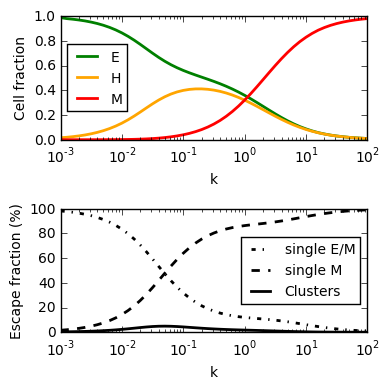

In [29]:
# plotting cell fractions and cluster escape fraction (Fig. 2A-B)

plt.figure(figsize=(4,4))

ax1 = plt.subplot2grid( (4,4), (0,0), rowspan=2, colspan=4 )
ax1.set_xscale('log')
plt.plot( k_emt, e_vec, 'g-', linewidth=2, label='E' )
plt.plot( k_emt, h_vec, '-', color='orange', linewidth=2, label='H' )
plt.plot( k_emt, m_vec, 'r-', linewidth=2, label='M' )
plt.xlabel('k')
plt.ylabel('Cell fraction')
plt.legend(loc='center left', fontsize=10)


ax2 = plt.subplot2grid( (4,4), (2,0), rowspan=2, colspan=4 )
ax2.set_xscale('log')
plt.plot( k_emt, 100*single_H, 'k-.', linewidth=2, label='single E/M' )
plt.plot( k_emt, 100*single_M, 'k--', linewidth=2, label='single M' )
plt.plot( k_emt, 100*clst_fr, 'k-', linewidth=2, label='Clusters' )
plt.xlabel('k')
plt.ylabel('Escape fraction (%)')
plt.legend(loc='center right', fontsize=10)

plt.tight_layout()
plt.show()

To generate k-c phase diagram (Fig. 2C) loop through cooperation parameter c as well as rate k.

Comparing with experimental CTC size distributions

In [31]:
# Experimental datasets:

# melanoma (Sarioglu et al. 2015)
xm = np.array([2,3,4,5,6,7])
ym = np.array([16.,5.,0.,2.,1.,0.])
summ = np.sum(ym)
err_mel = np.sqrt(ym)/summ
ym = ym/summ

# Breast cancer (bithi et al. 2017)
xbit = np.array([2,3,4,5,6,7,8])
ybit = np.array([186,161,74,74,50,74,0], dtype='float64')
ybit = ybit/np.sum(ybit)

# Prostate cancer (Kozminsky et al. 2018)
xk = np.array([2,3,4,5,6,7,8])
yk = np.array([52.,20.,9.,2.,1.,1.,1.])
sumk = np.sum(yk)
err_p = np.sqrt(yk)/sumk
yk = yk/sumk

# Breast cancer (Cheung et al. 2015)
x = np.arange(1,67,1)
y = np.zeros(x.size)
y[0] = 2
y[1] = 5
y[2] = 17
y[3] = 20
y[4] = 17
y[5] = 14
y[6] = 19
y[7] = 8
y[8] = 10
y[9] = 7
y[10] = 7
y[11] = 1
y[12] = 2
y[14] = 1
y[15] = 2
y[16] = 1
y[-1]=1
ysum = np.sum(y)
err_ch = np.sqrt(y)/ysum
y = y/ysum


### Glioblastoma (Krol et al. 2018)
xac = np.arange(2,16,1)
yac = np.array([13,11,14,13,10,6,8,5,0,3,2,0,1,0])
err_ac = np.sqrt(yac)
cum_a = np.zeros(yac.size-1)
for i in range(cum_a.size):
	cum_a[i] = np.sum(yac[i+1:])
suma = float(np.sum(yac))
n4 = int(suma)
cum_a = cum_a/suma
yac = yac/suma
err_ac = err_ac/suma

# breast cancer (Sarioglu et al. 2015)
xb = np.arange(0,20,1)
yb = np.zeros(xb.size)
yb[2]=36
yb[3]=26
yb[4]=11
yb[5]=9
yb[6]=3
yb[7]=3
yb[8]=1
yb[9]=4
yb[10]=1
yb[13]=2
yb[14]=1
yb[15]=1
yb[19]=1
sumb = np.sum(yb)
err_b = np.sqrt(yb)/sumb
yb = yb/sumb


# myeloma (Patil et al. 2019)
xmye = np.arange(3, 89, 1)
ymye = np.array([ 0.18309859,  0.34507042,  0.16901408,  0.07394366,  0.05985915,  0.02992958,
  0.01232394,  0.01408451,  0.01584507,  0.01232394,  0.00528169,  0.00352113,
  0.00528169,  0.00528169,  0.00352113,  0.00352113,  0.00352113,  0.00176056,
  0.00176056,  0.00176056,  0.00528169,  0.00352113,  0.00352113,  0.00880282,
  0.00176056,  0.00176056,  0.,          0.00176056,  0. ,         0.00176056,
  0.,          0.00176056,  0. ,         0.,          0.00352113,  0. ,         0.,
  0.00176056,  0.00176056,  0.,          0.00176056,  0.00176056,  0.00176056,
  0.  ,        0.,          0.,          0.,          0. ,         0.00176056,
  0. ,         0. ,         0. ,         0. ,         0. ,         0.,          0.,
  0. ,         0.,          0.,          0. ,         0. ,         0. ,         0.,
  0. ,         0.,          0.,          0.,          0.,          0. ,         0.,
  0. ,         0. ,         0. ,         0.00176056,  0. ,         0.,          0.,
  0.  ,        0. ,         0.,          0. ,         0.,          0.,
  0.00176056,  0.00176056 , 0.        ])

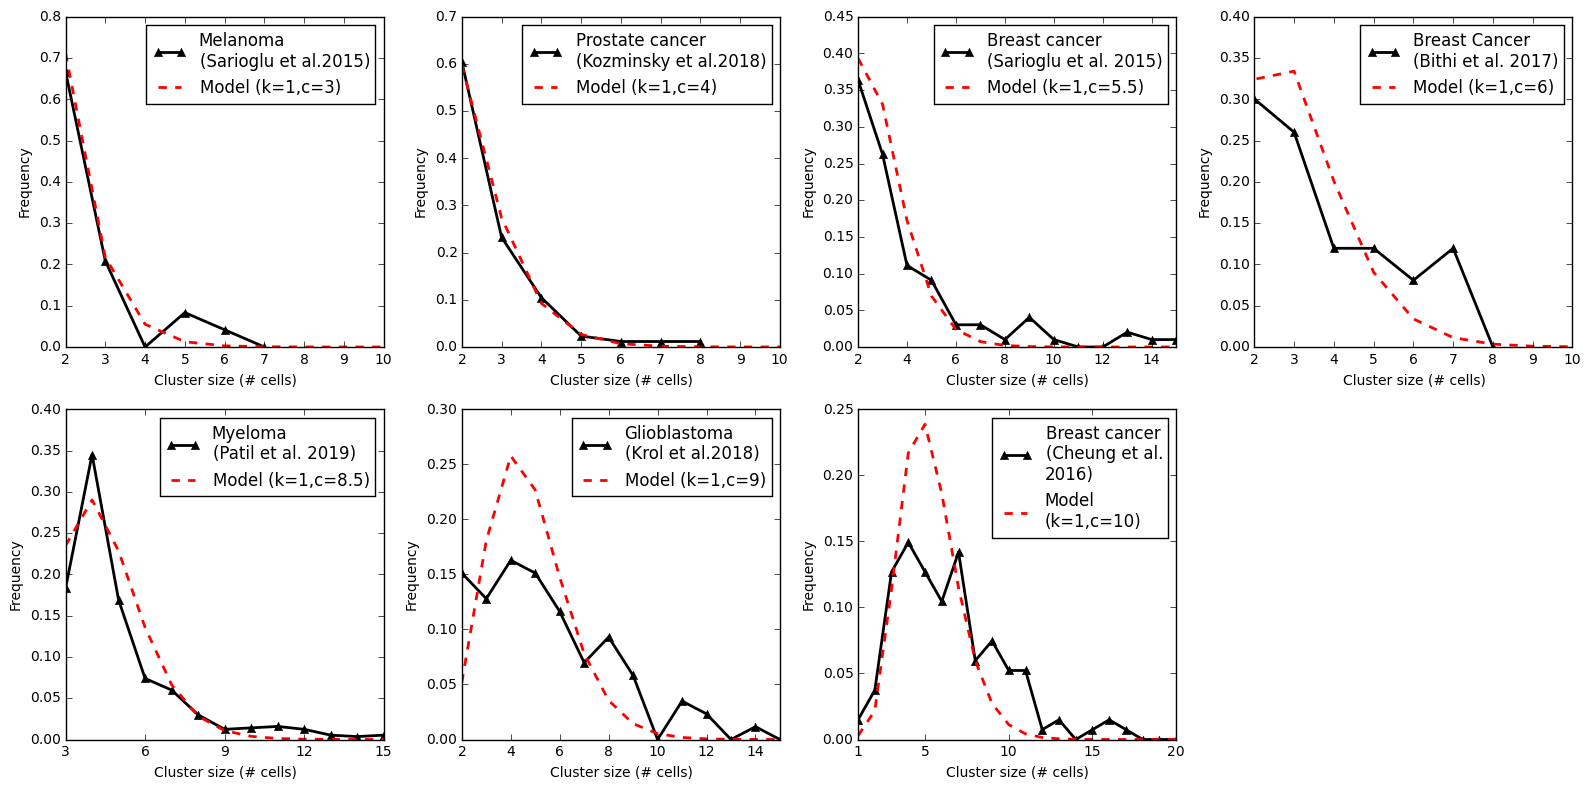

In [36]:
def compute_dist(c, k, pE, pH):
	# return distribution but NOT NORMALIZED
	tm, e, h, m = f.solve_model(c, k, pE, pH, two_dim=True)
	sum, clst_list = fd.cluster_sum(s.size, c, e[-1], h[-1], m[-1],  pE, pH, two_dim=True)
	dist = f.find_dist(clst_list)
	dist[0] = dist[0] + m[-1]
	return dist


pE = 0.5 
pH = 0.75 
s = np.arange(1,101,1)

plt.figure(figsize=(16,8))


ax1 = plt.subplot(241)
c = 3.
k = 1.
tm, e, h, m = solve_model(c, k, pE, pH, two_dim=True)
sum, clst_list = cluster_final(s.size, c, e[-1], h[-1], m[-1],  pE, pH, two_dim=True)
dist = find_dist(clst_list)
dist[0] = dist[0] + m[-1]
dist = dist/np.sum(dist[1:])

plt.plot( xm, ym,'k^-', linewidth=2, label='Melanoma\n(Sarioglu et al.2015)')
plt.plot(s[1:], dist[1:], 'r--', linewidth=2, label='Model (k=1,c=3)')
plt.xlim([2,10])
plt.ylim([0,0.8])
plt.xlabel('Cluster size (# cells)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=12)



ax2 = plt.subplot(242)
c = 4.
tm, e, h, m = solve_model(c, k, pE, pH, two_dim=True)
sum, clst_list = cluster_final(s.size, c, e[-1], h[-1], m[-1],  pE, pH, two_dim=True)
dist = find_dist(clst_list)
dist[0] = dist[0] + m[-1]
dist = dist/np.sum(dist[1:])

plt.plot( xk, yk, 'k^-', linewidth=2, label='Prostate cancer\n(Kozminsky et al.2018)')
plt.plot(s[1:], dist[1:], 'r--', linewidth=2, label='Model (k=1,c=4)')
plt.xlim([2,10])
plt.ylim([0,0.7])
plt.xlabel('Cluster size (# cells)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=12)



ax3 = plt.subplot(243)
c = 5.5
tm, e, h, m = solve_model(c, k, pE, pH, two_dim=True)
sum, clst_list = cluster_final(s.size, c, e[-1], h[-1], m[-1],  pE, pH, two_dim=True)
dist = find_dist(clst_list)
dist[0] = dist[0] + m[-1]
dist = dist/np.sum(dist[1:])

plt.plot( xb[2:], yb[2:], 'k^-', linewidth=2, label='Breast cancer\n(Sarioglu et al. 2015)')
plt.plot(s[1:], dist[1:], 'r--', linewidth=2, label='Model (k=1,c=5.5)')
plt.xlim([2,15])
plt.ylim([0,0.45])
plt.xlabel('Cluster size (# cells)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=12)



ax4 = plt.subplot(244)
c = 6
k = 1.
tm, e, h, m = solve_model(c, k, pE, pH, two_dim=True)
sum, clst_list = cluster_final(s.size, c, e[-1], h[-1], m[-1],  pE, pH, two_dim=True)
dist = find_dist(clst_list)
dist[0] = dist[0] + m[-1]
dist = dist/np.sum(dist[1:])

plt.plot( xbit, ybit, 'k^-', linewidth=2, label='Breast Cancer\n(Bithi et al. 2017)')
plt.plot(s, dist, 'r--', linewidth=2, label='Model (k=1,c=6)')
plt.xlim([2,10])
plt.ylim([0,0.4])
plt.xlabel('Cluster size (# cells)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=12)



ax5 = plt.subplot(245)
c = 8.5
k = 1.
tm, e, h, m = solve_model(c, k, pE, pH, two_dim=True)
sum, clst_list = cluster_final(s.size, c, e[-1], h[-1], m[-1],  pE, pH, two_dim=True)
dist = find_dist(clst_list)
dist[0] = dist[0] + m[-1]
dist = dist/np.sum(dist[2:])

plt.plot( xmye, ymye, 'k^-', linewidth=2, label='Myeloma\n(Patil et al. 2019)')
plt.plot(s[2:], dist[2:], 'r--', linewidth=2, label='Model (k=1,c=8.5)')
plt.xlim([3,15])
plt.xticks([3,6,9,12,15])
plt.ylim([0,0.4])
plt.xlabel('Cluster size (# cells)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=12)



ax6 = plt.subplot(246)
c = 9.
k = 1.
tm, e, h, m = solve_model(c, k, pE, pH, two_dim=True)
sum, clst_list = cluster_final(s.size, c, e[-1], h[-1], m[-1],  pE, pH, two_dim=True)
dist = find_dist(clst_list)
dist[0] = dist[0] + m[-1]
dist = dist/np.sum(dist[1:])

plt.plot( xac, yac,  'k^-', linewidth=2, label='Glioblastoma\n(Krol et al.2018)')
plt.plot(s[1:], dist[1:], 'r--', linewidth=2, label='Model (k=1,c=9)')
plt.xlim([2,15])
plt.ylim([0,0.3])
plt.xlabel('Cluster size (# cells)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=12)


ax7 = plt.subplot(247)
c = 10.
tm, e, h, m = solve_model(c, k, pE, pH, two_dim=True)
sum, clst_list = cluster_final(s.size, c, e[-1], h[-1], m[-1],  pE, pH, two_dim=True)
dist = find_dist(clst_list)
dist[0] = dist[0] + m[-1]
dist = dist/np.sum(dist)

plt.plot( x, y, 'k^-', linewidth=2 , label='Breast cancer\n(Cheung et al.\n2016)')
plt.plot(s, dist, 'r--', linewidth=2, label='Model\n(k=1,c=10)')
plt.xlim([1,20])
plt.xticks([1,5,10,15,20])
plt.xlabel('Cluster size (# cells)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', fontsize=12)



plt.tight_layout()
plt.show()

Model of partial EMT (varying EMT rates)

In [46]:
# Functions for the 2-state model (E-H)

def subcluster_sum_2(cp, e, h, s, pE, pH, two_dim=False):

	vec = np.zeros(s)
	
	# term coming from cluster of size s
	if two_dim:
		nE = 2 + 2*s*e
		nH = 2*s*h
		vec[s-1] = (s**cp)*( pE**nE )*( pH**nH )
	else:
		nE = 2
		vec[s-1] = (s**cp)*( pE**nE )

	# subcluster terms
	if s>1:
		# summation on k=[2,s]
		for p in np.arange(1,s,1):
			ms = float(p) # make it float for division
			if two_dim:
				nE = (2/(s-ms+1)) + 2*ms*e
				nH = (2/(s-ms+1)) + ((s-ms-1)/(s-ms+1)) + 2*ms*h
				vec[p-1] = (ms**cp)*( pE**nE )*( pH**nH )
			else:
				nE = (2/(s-ms+1))
				nH = (2/(s-ms+1)) + ((s-ms-1)/(s-ms+1))
				vec[p-1] = (ms**cp)*( pE**nE )*( pH**nH )
	return vec


def cluster_sum_2(cp, e, h, pE, pH, two_dim=False):
	
	if h==0:
		return 0., np.array([])
	else:
		epsilon = 0.0001
		c = 0.
		s = 1
		# vector to store contribution to escape rate by clusters if size s
		clst_list = []
		while ( s>0 ):
			sub_cont = subcluster_sum_2(cp, e, h, s, pE, pH, two_dim=two_dim)
			inc = (h**s)*((1-h)**2)*(2/(s*(s+1)))*np.sum( sub_cont )
			clst_list.append( (h**s)*((1-h)**2)*(2/(s*(s+1)))*( sub_cont ) )
			c = c + inc
			s = s + 1
			# whe exceeding cutoff, stop summing
			if inc/c < epsilon:
				break
		return c, clst_list
    
    
def solve_model_2(c, k, pE, pH, two_dim=False):
	
	if k>1.:
		dt = 0.001 #0.01
	else:
		dt = 0.01
	T = 10*max(1./k, 1.0) #10*max(k_emt, k_esc)
	tm = np.arange(0,T+dt,dt)
	npoints = int(T/dt)

	# define arrays to store e, h, m cell fraction
	e = np.zeros(npoints+1)
	h = np.zeros(npoints+1)

	# initial condition with all epithelial cells
	e[0] = 1.

	for i in range( npoints ):
		# compute energetic terms for cell-cell adhesion
	
		sum2, list = cluster_sum_2(c, e[i], h[i], pE, pH, two_dim=two_dim)
		
		e[i+1] = e[i] + dt*( -k*e[i] + sum2 )
		h[i+1] = h[i] + dt*( +k*e[i] - sum2 )
	
	return tm, e, h


### Functions for final distribution in 2-state model, slightly different

def find_dist_2(clst_list):
	maxs = len(clst_list)
	rates = np.zeros((maxs, maxs))
	dist = np.zeros(maxs)

	for i in range(maxs):
		for j in range(maxs):
			if j<clst_list[i].size:
				rates[i][j] = clst_list[i][j]
			else:
				rates[i][j] = 0.

	for i in range(maxs):
		dist[i] = np.sum( rates[:,i] )

	return dist


def cluster_sum_2_final(num, cp, e, h, pE, pH, two_dim=False):
	
	if h==0:
		return 0., np.array([])
	else:
		epsilon = 0.0001
		c = 0.
		# vector to store contribution to escape rate by clusters if size s
		clst_list = []
		for s in np.arange(1,num+1,1):
			sub_cont = subcluster_sum_2(cp, e, h, s, pE, pH, two_dim=two_dim)
			inc = ( 2*(h**s)*((1-h)**2)/(s*(s+1)) )*np.sum( sub_cont )
			clst_list.append( ( 2*(h**s)*((1-h)**2)/(s*(s+1)) )*( sub_cont ) )
			c = c + inc

		return c, clst_list

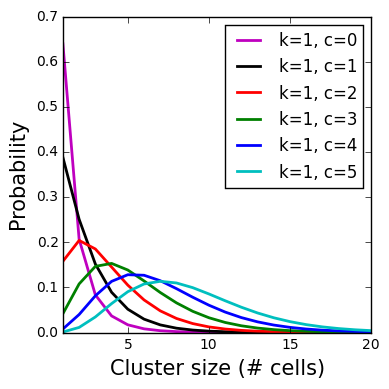

In [47]:
# Plot some distributions (Fig. 5D)

s = np.arange(1,101,1)
def find_dist_2_states(k, c):
	tm, e, h = solve_model_2(c, k, pE, pH, two_dim=True)
	sum, clst_list = cluster_sum_2_final(s.size, c, e[-1], h[-1],  pE, pH, two_dim=True)
	dist = find_dist_2(clst_list)
	dist = dist/np.sum(dist)
	return dist

plt.figure(figsize=(4,4))

dist_0 = find_dist_2_states(1., 0.)
plt.plot( s, dist_0, 'm-', linewidth=2, label='k=1, c=0' )
dist_1 = find_dist_2_states(1., 1.)
plt.plot( s, dist_1, 'k-', linewidth=2, label='k=1, c=1' )
dist_2 = find_dist_2_states(1., 2.)
plt.plot( s, dist_2, 'r-', linewidth=2, label='k=1, c=2' )
dist_3 = find_dist_2_states(1., 3.)
plt.plot( s, dist_3, 'g-', linewidth=2, label='k=1, c=3' )
dist_4 = find_dist_2_states(1., 4.)
plt.plot( s, dist_4, 'b-', linewidth=2, label='k=1, c=4' )
dist_5 = find_dist_2_states(1., 5.)
plt.plot( s, dist_5, 'c-', linewidth=2, label='k=1, c=5' )

plt.xlim([1,20])
plt.xlabel('Cluster size (# cells)', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()